In [1]:
import numpy as np 
import pandas as pd
# 시각화 package
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz

import matplotlib.font_manager as font_manager
from matplotlib import rc
   
# 한글폰트작업
# window의 폰트 위치 -> C:/Windows/Fonts/NGULIM.TTF
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/NGULIM.TTF").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# <font color = 4247D6> Data Set

In [2]:
df = pd.read_csv('이상치_제거_.csv')
df

,STD_DT,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04 0:00,489,116,631,OK
1,2020-03-04 0:00,433,78,609,OK
2,2020-03-04 0:00,464,154,608,OK
3,2020-03-04 0:00,379,212,606,OK
4,2020-03-04 0:00,798,1736,604,OK
...,...,...,...,...,...
835195,2020-04-30 23:59,755,1743,318,OK
835196,2020-04-30 23:59,385,206,317,OK
835197,2020-04-30 23:59,465,148,316,OK
835198,2020-04-30 23:59,467,0,314,OK


In [3]:
df.replace({'TAG': {'OK': 1, 'NG': 0}}, inplace=True)
df

,STD_DT,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04 0:00,489,116,631,1
1,2020-03-04 0:00,433,78,609,1
2,2020-03-04 0:00,464,154,608,1
3,2020-03-04 0:00,379,212,606,1
4,2020-03-04 0:00,798,1736,604,1
...,...,...,...,...,...
835195,2020-04-30 23:59,755,1743,318,1
835196,2020-04-30 23:59,385,206,317,1
835197,2020-04-30 23:59,465,148,316,1
835198,2020-04-30 23:59,467,0,314,1


In [4]:
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tcn import TCN, tcn_full_summary
from keras.layers import Dropout
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
df['STD_DT'] = df['STD_DT'].apply(lambda x: pd.to_datetime(str(x), format = '%Y-%m-%d %H:%M:%S'))

In [7]:
df = df.set_index(['STD_DT'])
df

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
STD_DT,,,,
2020-03-04 00:00:00,489,116,631,1
2020-03-04 00:00:00,433,78,609,1
2020-03-04 00:00:00,464,154,608,1
2020-03-04 00:00:00,379,212,606,1
2020-03-04 00:00:00,798,1736,604,1
...,...,...,...,...
2020-04-30 23:59:00,755,1743,318,1
2020-04-30 23:59:00,385,206,317,1
2020-04-30 23:59:00,465,148,316,1


In [8]:
# df.replace({'TAG': {'OK': 1, 'NG': 0}}, inplace=True)
df1 = df[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'TAG']]
df1

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
STD_DT,,,,
2020-03-04 00:00:00,489,116,631,1
2020-03-04 00:00:00,433,78,609,1
2020-03-04 00:00:00,464,154,608,1
2020-03-04 00:00:00,379,212,606,1
2020-03-04 00:00:00,798,1736,604,1
...,...,...,...,...
2020-04-30 23:59:00,755,1743,318,1
2020-04-30 23:59:00,385,206,317,1
2020-04-30 23:59:00,465,148,316,1


In [39]:
split_date = int(df1.shape[0]*0.5)
train = df1[split_date:]
test = df1[:split_date]
print(train.shape)
print(test.shape)

(417600, 4)
(417600, 4)


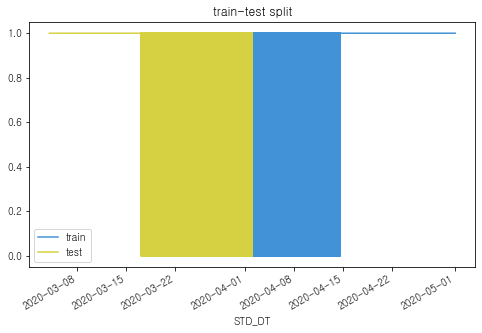

In [40]:
df1['TAG'][split_date:].plot(figsize=(8, 5), legend=True, color= '#4192D6')
df1['TAG'][:split_date].plot(figsize=(8, 5), legend=True, color= '#d6d142')
plt.legend(['train', 'test'])
plt.title('train-test split')
plt.show()

In [41]:
scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

x_train_values = train_sc[:, :-1]
y_train_values = train_sc[:,-1]

In [42]:
smote = SMOTE(random_state = 0)

X_train_over, y_train_over = smote.fit_resample(x_train_values, y_train_values)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트', x_train_values.shape, y_train_values.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 (417600, 3) (417600,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 (723298, 3) (723298,)
SMOTE 적용 후 레이블 값 분포: 
 1.0    361649
0.0    361649
dtype: int64


In [43]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [44]:
X_train_over = pd.DataFrame(X_train_over, columns = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT'])
y_train_over = pd.DataFrame(y_train_over, columns = ['TAG'])

In [45]:
#train dataset
train_feature, train_label = make_dataset(X_train_over, y_train_over, 10)

In [46]:
test_sc = pd.DataFrame(test_sc, columns = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT','TAG'])

In [47]:
feature_cols = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT']
label_cols = ['TAG']

In [48]:
test_feature = test_sc[feature_cols]
test_label = test_sc[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 10)
test_feature.shape, test_label.shape

((417590, 10, 3), (417590, 1))

In [49]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.3,random_state=1)
x_train.shape, x_valid.shape

((506301, 10, 3), (216987, 10, 3))

In [50]:
import os
path = "C:/Users/islab/Desktop/jihyeon/전자제조시스템"
os.chdir(path)

In [51]:
model_path = path

In [52]:
model = Sequential()
model.add(LSTM(50, 
               input_shape = (train_feature.shape[1], train_feature.shape[2]), activation = 'tanh', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(1, activation = 'sigmoid'))

In [53]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor = 'val_loss', patience = 8)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')

In [54]:
history = model.fit(x_train, y_train, epochs = 200, batch_size = 10, validation_data = (x_valid, y_valid), callbacks = [early_stop, checkpoint])

Epoch 1/200
50631/50631 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9223
Epoch 1: val_loss improved from inf to 0.18590, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
50631/50631 [==============================] - 536s 10ms/step - loss: 0.1890 - accuracy: 0.9223 - val_loss: 0.1859 - val_accuracy: 0.9221
Epoch 2/200
50631/50631 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9228
Epoch 2: val_loss improved from 0.18590 to 0.18578, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
50631/50631 [==============================] - 502s 10ms/step - loss: 0.1859 - accuracy: 0.9228 - val_loss: 0.1858 - val_accuracy: 0.9221
Epoch 3/200
50631/50631 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.9207
Epoch 3: val_loss did not improve from 0.18578
50631/50631 [==============================] - 506s 10ms/step - loss: 0.1906 - accuracy: 0.9207 - val_loss: 0.1860 - val_accurac

In [55]:
pred = model.predict(test_feature)

13050/13050 [==============================] - 37s 3ms/step


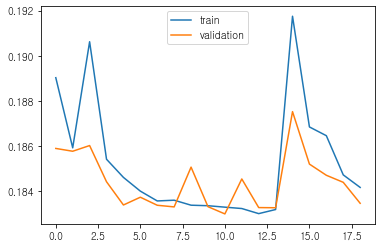

In [56]:
plt.plot(history.history["loss"],label="train")
plt.plot(history.history["val_loss"],label="validation")
plt.legend()
plt.show()

In [57]:
pred_df = pd.DataFrame(pred, columns=['TAG'])

pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x>=0.5 else 0)

In [58]:
confusion = confusion_matrix(test_label, pred_df)
print(confusion)

[[   186 120930]
 [   129 296345]]


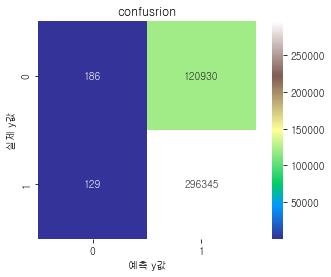

In [59]:
plot = sns.heatmap(confusion ,square=True, annot=True, fmt='d', cmap='terrain')
class_lables=['0','1','2','3']
plt.title("confusrion", size = 12)
plot.set_xlabel('예측 y값')
plot.set_ylabel('실제 y값')
# plt.savefig('80% 사후확률_min_{}_수정.png'.format(j), dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [60]:
p = precision_score(test_label, pred_df)
print('precision : %0.5f' %p)
r = recall_score(test_label, pred_df)
print('recall : %0.5f' %r)
f1 = f1_score(test_label, pred_df)
print('f1-score : %0.5f' %f1)
acc = accuracy_score(test_label, pred_df)
print('accuracy : %0.5f' %acc)

precision : 0.71019
recall : 0.99956
f1-score : 0.83039
accuracy : 0.71010


In [61]:
# test_label
test_df = pd.DataFrame(test_label, columns=['TAG'])
test_df

,TAG
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
417585,1.0
417586,0.0
417587,1.0
417588,0.0


In [62]:
pred_df

,TAG
0,1
1,1
2,1
3,1
4,1
...,...
417585,1
417586,1
417587,1
417588,1


In [75]:
test_1 = df1[:split_date]
test_2 = test_1[10:]
test_2
x = test_2['TAG'].values.tolist()
# test_1

In [76]:
c = confusion_matrix(x, test_df)
print(c)

[[121116      0]
 [     0 296474]]


In [77]:
y = pred_df['TAG'].values.tolist()

In [78]:
test_2['predict'] = y
test_2

C:\Users\islab\AppData\Local\Temp\ipykernel_28868\1846207918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2['predict'] = y


,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG,predict
STD_DT,,,,,
2020-03-04 00:01:00,507,128,596,1,1
2020-03-04 00:01:00,408,66,595,1,1
2020-03-04 00:01:00,474,138,594,1,1
2020-03-04 00:01:00,358,201,592,1,1
2020-03-04 00:01:00,740,1740,590,1,1
...,...,...,...,...,...
2020-04-01 23:59:00,786,1759,748,1,1
2020-04-01 23:59:00,417,178,747,0,1
2020-04-01 23:59:00,469,195,745,1,1


In [79]:
test_2.to_csv('사후확률_2.csv')

In [80]:
test_2

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG,predict
STD_DT,,,,,
2020-03-04 00:01:00,507,128,596,1,1
2020-03-04 00:01:00,408,66,595,1,1
2020-03-04 00:01:00,474,138,594,1,1
2020-03-04 00:01:00,358,201,592,1,1
2020-03-04 00:01:00,740,1740,590,1,1
...,...,...,...,...,...
2020-04-01 23:59:00,786,1759,748,1,1
2020-04-01 23:59:00,417,178,747,0,1
2020-04-01 23:59:00,469,195,745,1,1
